In [1]:
import enum
from abc import ABC, abstractmethod

import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Question 1

In [2]:
class Market:
  def __init__(self, r, sig):
    self.r = r
    self.sig = sig

In [3]:
class Underlying:
  def __init__(self, S, q, market):
    self.S = S
    self.q = q
    self.market = market

In [4]:
class Derivative(ABC):

  def __init__(self, underlying, K, T):
      self.underlying = underlying
      self.K = K
      self.T = T

  @abstractmethod
  def get_exact_price(self):
        pass

  @abstractmethod
  def get_mc_gbm_price(self):
        pass  

In [5]:
class OptionType(enum.Enum):
    CALL = 1
    PUT = 2

In [6]:
class ConfidenceInterval:
  def __init__(self, lowerbound, upper):
    self.lower = lowerbound
    self.upper = upper
   # self.sd = 1

  def to_string(self):
    return "[" + str(self.lower) + ", " + str(self.upper) + "]"

In [7]:
def compute_interval(value, N, std, level=.95,  dist="gauss"):
    if level == .95 and dist == "gauss":
      lower = value - ((1.96*std)/np.sqrt(N))    
      upper = value + ((1.96*std)/np.sqrt(N))    
      return ConfidenceInterval(lower, upper)

In [8]:
class EuropeanOption(Derivative):

  def __init__(self, underlying, K, T, type):
    super().__init__(underlying, K, T)
    self.type = type
    self.S = underlying.S
    self.r = underlying.market.r
    self.q = underlying.q
    self.sig = underlying.market.sig


  def get_exact_price(self):
    d1 = (np.log(self.S/self.K)+((self.r-self.q)+0.5*self.sig**2)*self.T)/(self.sig*np.sqrt(self.T))
    d2 = d1 - self.sig*np.sqrt(self.T)

    price = 0

    if self.type == OptionType.CALL:
      price = self.S*np.exp(-self.q*self.T)*stats.norm.cdf(d1) - self.K*np.exp(-self.r*self.T)*stats.norm.cdf(d2)
    else:
      price = self.K*np.exp(-self.r*self.T)*stats.norm.cdf(-d2) - self.S*np.exp(-self.q*self.T)*stats.norm.cdf(-d1)
    
    return price


  def get_mc_gbm_price(self, N, z):
      ST = self.S*np.exp((self.r-self.q-0.5*self.sig**2)*self.T + self.sig*np.sqrt(self.T)*z)
      
      if self.type == OptionType.CALL:
        disc_payoff = np.exp(-self.r*self.T)*np.maximum(ST-self.K, 0)
        std = np.std(disc_payoff)
        price = np.mean(disc_payoff)
        return N, price, compute_interval(price, N, std).to_string()
      else:
        disc_payoff = np.exp(-self.r*self.T)*np.maximum(self.K-ST, 0)
        std = np.std(disc_payoff)
        price = np.mean(disc_payoff)
        return N, price, compute_interval(price, N, std).to_string()


  def compute_mc_gbm_price(self, N, antithetical_draw=False, handle_error=True):
    z = np.random.normal(size=N)
    if antithetical_draw:
      if N % 2 != 0:
        if handle_error:
          N += 1
        else:
          raise ValueError('N has to be divisible by 2.')

      z2 = -1 * z # we use the same samples instead of sampling again
      v1 = self.get_mc_gbm_price(N, z)[1]
      v2 = self.get_mc_gbm_price(N, z2)[1]
      return .5 * (v1 + v2)
    else: 
      return self.get_mc_gbm_price(N, z)


  def get_delta(self):
    if self.type == OptionType.CALL:
      d1 = (np.log(self.S/self.K)+((self.r-self.q)+0.5*self.sig**2)*self.T)/(self.sig*np.sqrt(self.T))
      return np.exp(-self.q*self.T)*stats.norm.cdf(d1)
    else:
      d1 = (np.log(self.S/self.K)+((self.r-self.q)+0.5*self.sig**2)*self.T)/(self.sig*np.sqrt(self.T))
      return np.exp(-self.q*self.T)*(stats.norm.cdf(d1)-1)

  def set_S(self, S):
    self.S = S

In [9]:
class ForwardContract(Derivative):
  def __init__(self, underlying, K, T):
    super().__init__(underlying, K, T)
    self.S = underlying.S
    self.r = underlying.market.r
    self.q = underlying.q
    self.sig = underlying.market.sig

  def get_exact_price(self, call, put):
    #determining the exact price using put call parity
    forward = call-put
    return forward 


  def get_mc_gbm_price(self, N, z):
    z = np.random.normal(size=N)
    ST = self.S*np.exp((self.r-self.q-0.5*self.sig**2)*self.T + self.sig*np.sqrt(self.T)*z)

    ST_K = ST - self.K
    disc = ST_K * np.exp(-self.r*self.T)
    std = np.std(disc)
    price = np.mean(disc)

    return N, price, compute_interval(price, N, std).to_string()


  def compute_mc_gbm_price(self, N, antithetical_draw=False, handle_error=True):
    z = np.random.normal(size=N)
    if antithetical_draw:
      if N % 2 != 0:
        if handle_error:
          N += 1
        else:
          raise ValueError('N has to be divisible by 2.')
      z2 = -1 * z # we use the same samples instead of sampling again
      v1 = self.get_mc_gbm_price(N, z)[1]
      v2 = self.get_mc_gbm_price(N, z2)[1]
      return .5 * (v1 + v2)
    else: 
      return self.get_mc_gbm_price(N, z)

In [10]:
S = 180
K = 160
sig = .2
r = .01
q = .015
T = 88/365 # or 89 if last day is added

tol = .1

m = 100_000

In [11]:
market = Market(r, sig)

In [12]:
underlying_a = Underlying(S, q, market)

In [13]:
call_a = EuropeanOption(underlying_a, K, T, OptionType.CALL)

In [14]:
put_a = EuropeanOption(underlying_a, K, T, OptionType.PUT)

In [15]:
forward_a = ForwardContract(underlying_a, K , T)

## a)

### i)

In [16]:
def estimate_N(m, tol, derivative):
    # 95 % confidence interval
    z = np.random.normal(size=m)
    
    ST = derivative.S*np.exp((derivative.r-derivative.q-0.5*derivative.sig**2)*derivative.T + derivative.sig*np.sqrt(derivative.T)*z)

    f_zi = 0

    if type(derivative) is EuropeanOption:
      if derivative.type is OptionType.CALL:
        f_zi = np.exp(-derivative.r*derivative.T)*np.maximum(ST-derivative.K, 0)
      else:
        f_zi = np.exp(-derivative.r*derivative.T)*np.maximum(derivative.K - ST, 0)
    elif type(derivative) is ForwardContract:
      ST_K = ST - derivative.K
      f_zi = ST_K * np.exp(-derivative.r*derivative.T)
    else:
      mean = np.zeros((2))
      rho = derivative.rho
      cov = [[1, derivative.rho],
            [derivative.rho, 1]]

      corr_bm = np.random.multivariate_normal(mean, cov, size=m)

      z1 = corr_bm[:, 0]
      z2 = corr_bm[:, 1]

      ST1 = derivative.S*np.exp((derivative.r-derivative.q-0.5*derivative.sig**2)*derivative.T + derivative.sig*np.sqrt(derivative.T)*z1)
      ST2 = derivative.S2*np.exp((derivative.r2-derivative.q2-0.5*derivative.sig2**2)*derivative.T + derivative.sig2*np.sqrt(derivative.T)*z2)

      disc_ST1 = np.exp(-derivative.r*derivative.T)*ST1
      disc_ST2 = np.exp(-derivative.r2*derivative.T)*ST2

      if derivative.type == OptionType.CALL:
        f_zi = np.maximum(disc_ST1-disc_ST2-derivative.K, 0)
      else:
        f_zi = np.maximum(0, K - disc_ST1  + disc_ST2)

    sm = np.std(f_zi)

    return ((1.96 * sm) / tol)**2

In [17]:
estimate_N(m, tol, call_a)

100315.87459432008

In [18]:
estimate_N(m, tol, put_a)

4299.474439861093

In [19]:
estimate_N(m, tol, forward_a)

120118.20686712886

### ii and ii)

In [20]:
exact_price_call = EuropeanOption(underlying_a, K, T, OptionType.CALL).get_exact_price()
print(exact_price_call)

20.691818313854952


In [21]:
call_a.get_delta()

0.8885902097987676

In [22]:
exact_price_put = EuropeanOption(underlying_a, K, T, OptionType.PUT).get_exact_price()
print(exact_price_put)

0.9563127789310322


In [23]:
put_a.get_delta()

-0.10779988328237437

In [24]:
EuropeanOption(underlying_a, K, T, OptionType.CALL).compute_mc_gbm_price(int(estimate_N(m, tol, call_a)))

(100398, 20.67111625373186, '[20.571283341083102, 20.770949166380618]')

In [25]:
EuropeanOption(underlying_a, K, T, OptionType.PUT).compute_mc_gbm_price(int(estimate_N(m, tol, put_a)))

(4273, 0.9575922987079162, '[0.8569092107162637, 1.0582753866995687]')

In [26]:
f_simulated = forward_a.compute_mc_gbm_price(int(estimate_N(m, tol, call_a)))
f_exact = forward_a.get_exact_price(exact_price_call, exact_price_put)
print(f_simulated)
print(f_exact)

(99185, 19.799044777238386, '[19.68917423895155, 19.90891531552522]')
19.73550553492392


## b)


In [27]:
M = 1000
outcomes1 = np.zeros((3, M))

for i in range(M):
  outcomes1[0][i] = call_a.compute_mc_gbm_price(int(estimate_N(m, tol, call_a)))[1]
  outcomes1[1][i] = put_a.compute_mc_gbm_price(int(estimate_N(m, tol, put_a)))[1]
  outcomes1[2][i] = forward_a.compute_mc_gbm_price(int(estimate_N(m, tol, forward_a)))[1]

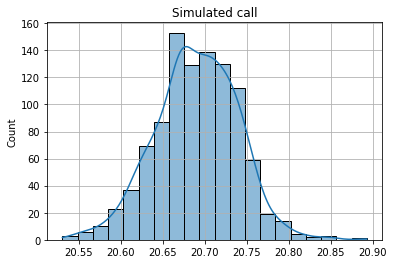

In [28]:
sns.histplot(outcomes1[0, :], bins=20, kde=True)
plt.grid()
plt.title("Simulated call")
plt.show()

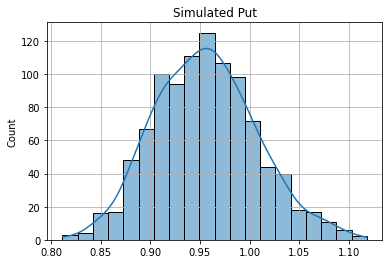

In [29]:
sns.histplot(outcomes1[1, :], bins=20, kde=True)
plt.grid()
plt.title("Simulated Put")
plt.show()

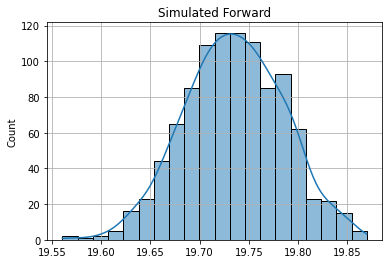

In [30]:
sns.histplot(outcomes1[2, :], bins=20, kde=True)
plt.grid()
plt.title("Simulated Forward")
plt.show()

## c)

In [31]:
outcomes2 = np.zeros((3, M))

for i in range(M):
  outcomes2[0][i] = call_a.compute_mc_gbm_price(int(estimate_N(m, tol, call_a)), True)
  outcomes2[1][i] = put_a.compute_mc_gbm_price(int(estimate_N(m, tol, put_a)), True)
  outcomes2[2][i] = forward_a.compute_mc_gbm_price(int(estimate_N(m, tol, forward_a)), True)

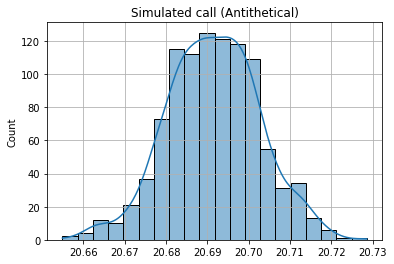

In [32]:
sns.histplot(outcomes2[0, :], bins=20, kde=True)
plt.grid()
plt.title("Simulated call (Antithetical)")
plt.show()

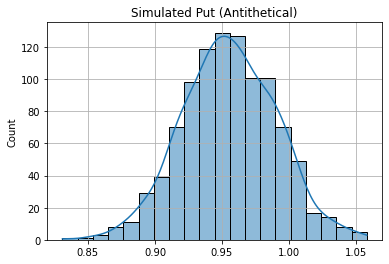

In [33]:
sns.histplot(outcomes2[1, :], bins=20, kde=True)
plt.grid()
plt.title("Simulated Put (Antithetical)")
plt.show()

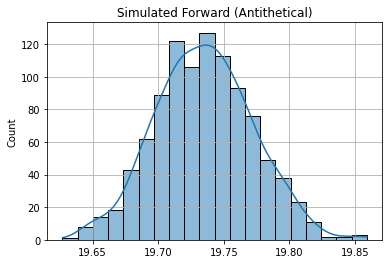

In [34]:
sns.histplot(outcomes2[2, :], bins=20, kde=True)
plt.grid()
plt.title("Simulated Forward (Antithetical)")
plt.show()

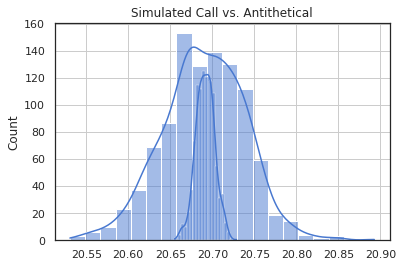

In [35]:
#df = pd.DataFrame({"Not Antithetical": outcomes1[0, :],
                 #"Antithetical" : outcomes2[0, :]})

sns.set(color_codes=True)
sns.set(style="white", palette="muted")
#sns.histplot(data=df)
sns.histplot(outcomes1[0, :], bins=20, kde=True)
sns.histplot(outcomes2[0, :], bins=20, kde=True)
plt.grid()
plt.title("Simulated Call vs. Antithetical")
plt.show()

In order to asses whether antithetical draws converge much faster we can gather the sample moments. (could use MLE)

In [36]:
np.mean(outcomes1[0, :]), np.var(outcomes1[0, :]), np.mean(outcomes2[0, :]), np.var(outcomes2[0, :])

(20.689959614786428,
 0.0023816583289724773,
 20.691467083247446,
 0.00012318573421112828)

We observe that we experience significantly less variance

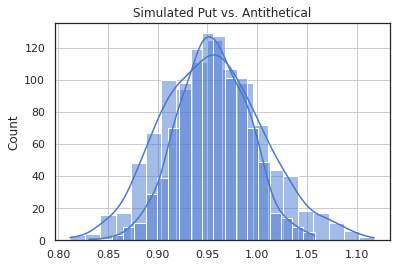

In [37]:
sns.set(color_codes=True)
sns.set(style="white", palette="muted")
#sns.histplot(data=df)
sns.histplot(outcomes1[1, :], bins=20, kde=True)
sns.histplot(outcomes2[1, :], bins=20, kde=True)
plt.grid()
plt.title("Simulated Put vs. Antithetical")
plt.show()

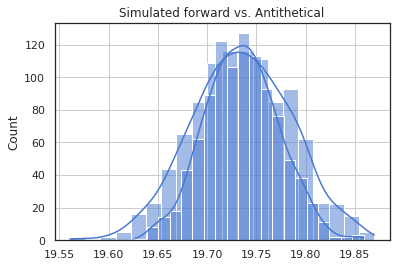

In [38]:
sns.set(color_codes=True)
sns.set(style="white", palette="muted")
#sns.histplot(data=df)
sns.histplot(outcomes1[2, :], bins=20, kde=True)
sns.histplot(outcomes2[2, :], bins=20, kde=True)
plt.grid()
plt.title("Simulated forward vs. Antithetical")
plt.show()

Overall, we can see, that the antithetical draw gives us much better values than
the traditional methods, which was expected based on the proofs in the class.

## d)

In [39]:
def shiftdelta(option_t1, option_t2, e, iid=True):
  z1 = np.random.normal(size=m)
  if iid:
    z2 = np.random.normal(size=m)
    return (option_t1.get_mc_gbm_price(m, z1)[1] - option_t2.get_mc_gbm_price(m, z2)[1]) / e
  else:
    return (option_t1.get_mc_gbm_price(m, z1)[1] - option_t2.get_mc_gbm_price(m, z1)[1]) / e

In [40]:
e = .01 * S
underlying_b = Underlying(S + e, q, market)
underlying_a = Underlying(S, q, market)
option_t1 =  EuropeanOption(underlying_b, K, T, OptionType.CALL)
option_t2 = EuropeanOption(underlying_a, K, T, OptionType.CALL)

### i)

In [41]:
shiftdelta(option_t1, option_t2, e)

0.8544444193246924

In [42]:
option_t2.get_delta() # the true delta

0.8885902097987676

In [43]:
option_t1_put = EuropeanOption(underlying_b, K, T, OptionType.PUT)
option_t2_put = EuropeanOption(underlying_a, K, T, OptionType.PUT)

In [44]:
shiftdelta(option_t1_put, option_t2_put, e)

-0.09856921678535338

### ii)

In [45]:
shiftdelta(option_t1, option_t2, e, False)

0.8968948274703376

As we can see the call is in the money which naturally corresponds to a higher delta. We have a true value of 0.891. The put on the other hand, is pretty deep out of the money implying a delta close to 0 (real value -.11). 

In [46]:
antithetical_delta_shift = list()
delta_shift = list()

underlying_unshifted = Underlying(S, q, market)
e = 0
for epsilon in np.linspace(0.001, 0.1, 100):
  e = epsilon * S

  underlying_shifted = Underlying(S + e, q, market)
  option_shifted =  EuropeanOption(underlying_shifted, K, T, OptionType.CALL)
  option_unshifted = EuropeanOption(underlying_unshifted, K, T, OptionType.CALL)

  
  #print(shiftdelta(option_shifted, option_unshifted, e), e)
  delta_shift.append(shiftdelta(option_shifted, option_unshifted, e))
  antithetical_delta_shift.append(shiftdelta(option_shifted, option_unshifted, e, False))


#plt.plot()
#print("Shifted by", e, eps, "yields", shiftdelta(option_t1, option_t2, eps))

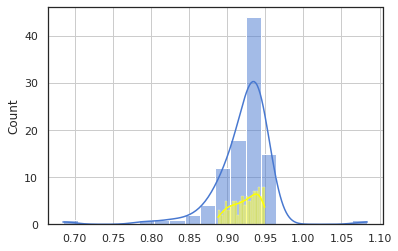

In [47]:
sns.histplot(delta_shift, bins=20, kde=True)
sns.histplot(antithetical_delta_shift, bins=20, color="yellow", kde=True)
plt.grid()
plt.show()

In [48]:
print("i.i.d. mean and variance:", np.mean(delta_shift), np.var(delta_shift))

i.i.d. mean and variance: 0.9204735754576641 0.0016350513005174594


In [49]:
print("same mean and variance:", np.mean(antithetical_delta_shift), np.var(antithetical_delta_shift))

same mean and variance: 0.9237912747370761 0.00029712620127918347


### iii)

As we can see in the histogram above, using the second method (yellow in the above graphic), where the samples z1 and z2 are not i.i.d., but instead the same, we gut much better delta values, especially the variance is less than the i.i.d. method. We have some extreme outliers in by sampling i.i.d. This is because when we sample i.i.d. we first sample two different path outcomes and then take the difference, whereas if we use the same values we just take the difference, leaving everything but the shift unchanged.

# Question 2

In [50]:
rho = 0.7
dt = 0.01
N = 100_000

In [51]:
class SpreadOption(Derivative):
  def __init__(self, underlying1, underlying2, K, T, rho, type):
    super().__init__(underlying1, K, T)
    self.type = type
    self.underlying2 = underlying2

    self.S = underlying1.S
    self.r = underlying1.market.r
    self.q = underlying1.q
    self.sig = underlying1.market.sig

    self.S2 = self.underlying2.S
    self.r2 = self.underlying2.market.r
    self.q2 = self.underlying2.q
    self.sig2 = self.underlying2.market.sig
    self.rho = rho

  
  def get_exact_price(self):
    pass

  def get_mc_gbm_price(self, tol):

    N = int(estimate_N(m, tol, self))
    
    mean = np.zeros((2))
    rho = self.rho
    cov = [[1, self.rho],
           [self.rho, 1]]

    corr_bm = np.random.multivariate_normal(mean, cov, size=N)

    z1 = corr_bm[:, 0]
    z2 = corr_bm[:, 1]

    ST1 = self.S*np.exp((self.r-self.q-0.5*self.sig**2)*self.T + self.sig*np.sqrt(self.T)*z1)
    ST2 = self.S2*np.exp((self.r2-self.q2-0.5*self.sig2**2)*self.T + self.sig2*np.sqrt(self.T)*z2)

    payoff = 0

    if self.type == OptionType.CALL:
      payoff = np.maximum(ST1 - ST2 - self.K, 0)
    else:
      payoff = np.maximum(0, self.K - ST1  + ST2)

    disc_payoff = np.exp(-self.r*self.T)*payoff

    price = np.mean(disc_payoff)

    return price

In [52]:
class SpreadTrade:
  def __init__(self, spread_option):
    self.spread_option = spread_option
    self.type = self.spread_option.type


  def get_trade_price(self, tol):
    return self.spread_option.get_mc_gbm_price(tol)

In [53]:
S1 = 180 
S2 = 160 
q1 = .01 
q2 = .015
K = 20
sig = 20 
r = .02 
rho = .7
tol = 0.10 
T = 180 / 365

In [54]:
underlying_2_a = Underlying(S1, q1, market)
underlying_2_b = Underlying(S2, q2, market)


spread_call = SpreadOption(underlying_2_a, underlying_2_b, K, T, rho, OptionType.CALL)
spread_trade_call = SpreadTrade(spread_call)

spread_put = SpreadOption(underlying_2_a, underlying_2_b, K, T, rho, OptionType.PUT)
spread_trade_put = SpreadTrade(spread_put)

In [55]:
estimate_N(m, tol, spread_call)

49059.3253918432

In [56]:
estimate_N(m, tol, spread_put)

44065.022499518505

In [57]:
spread_call_price = spread_trade_call.get_trade_price(tol)
print(spread_call_price)

7.6697296698232815


In [58]:
spread_put_price = spread_trade_put.get_trade_price(tol)
print(spread_put_price)

7.27879333464814


For Put-Call-Parity: C-P = F ⇔ C-P-F = 0



In [59]:
put_call_parity_sim = 0
for i in range(1000):
  spread_call_price = spread_trade_call.get_trade_price(tol)
  spread_put_price = spread_trade_put.get_trade_price(tol)
  forward_spread_price = S1*np.exp(-q1*T) - S2*np.exp(-q2*T) - K * np.exp(-r*T)
  put_call_parity_sim += spread_call_price - spread_put_price - forward_spread_price

print(put_call_parity_sim/M)

-0.09882587010843814


We have simulated the value of the put call parity 1000 times an got an average value of -0.09 which implies that the put-call-parity holds

#### Just for fun

In [60]:
def correlated_gbm(N, dt, rho):
  """
  Built on the basis of: https://quant.stackexchange.com/questions/24472/two-correlated-brownian-motions
  """
  W1 = np.zeros((N))
  W2 = np.zeros((N))


  for i in range(1, N):
    dW1 = np.random.normal(0, np.sqrt(dt))
    W1[i] = W1[i-1] + dW1
    W2[i] = rho * W1[i] + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt))

  return W1, W2

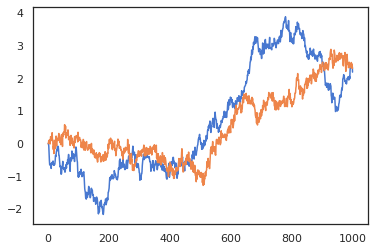

In [61]:
plt.plot(correlated_gbm(1_000, dt,.7)[0])
plt.plot(correlated_gbm(1_000, dt,.7)[1])